# IMPORT THE FRAMEWORKS


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")
# Set option to display all columns (useful for inspection)
pd.set_option('display.max_columns', None)


# LOAD THE DATATSETS

In [2]:
file_path = '/content/drive/MyDrive/1730285881-Airbnb_Open_Data.xlsx'
try:
    # Use pd.read_excel for .xlsx files
    df = pd.read_excel(file_path)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the filename and path.")
    # Exit if file not found to prevent errors in subsequent steps
    # In a notebook, exiting might stop the kernel.
    # A better approach is to set a flag or handle the error gracefully
    # to allow other cells to run if they don't depend on the dataframe.
    # For now, we'll just print the error and let subsequent cells potentially fail
    # if they require the dataframe.
    pass # Removed exit()

Dataset loaded successfully!


# VISUALIZING THE DATA

In [3]:
print("\n--- Initial DataFrame Info ---")
df.info()



--- Initial DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   id                              102599 non-null  int64         
 1   NAME                            102329 non-null  object        
 2   host id                         102599 non-null  int64         
 3   host_identity_verified          102310 non-null  object        
 4   host name                       102191 non-null  object        
 5   neighbourhood group             102570 non-null  object        
 6   neighbourhood                   102583 non-null  object        
 7   lat                             102591 non-null  float64       
 8   long                            102591 non-null  float64       
 9   country                         102067 non-null  object        
 10  country code            

In [4]:
print("\nFirst 5 rows of the data:")
print(df.head())


First 5 rows of the data:
        id                                              NAME      host id  \
0  1001254                Clean & quiet apt home by the park  80014485718   
1  1002102                             Skylit Midtown Castle  52335172823   
2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556   
3  1002755                                               NaN  85098326012   
4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077   

  host_identity_verified host name neighbourhood group neighbourhood  \
0            unconfirmed  Madaline            Brooklyn    Kensington   
1               verified     Jenna           Manhattan       Midtown   
2                    NaN     Elise           Manhattan        Harlem   
3            unconfirmed     Garry            Brooklyn  Clinton Hill   
4               verified    Lyndon           Manhattan   East Harlem   

        lat      long        country country code  instant_bookable  \
0  40.

# DATA WRANGLING AND CLEANING

In [5]:
# --- 2.1 Standardize Column Names
# Clean up column names by removing spaces and converting to lowercase
df.columns = df.columns.str.lower().str.replace(' ', '_')

# --- 2.2 Handling Missing Values (Imputation/Removal) ---
# Display missing value counts (before and after cleaning)
print("\n--- Missing Values Check (Top 10) ---")
print(df.isnull().sum().sort_values(ascending=False).head(10))

# For 'host_identity_verified', impute missing values with 'unconfirmed'
df['host_identity_verified'].fillna('unconfirmed', inplace=True)

# For numerical columns like 'reviews_per_month', 'last_review', 'review_rate_number',
# we can impute with 0 or the median/mode depending on the context.
# We'll use 0 for review-related metrics, assuming NaN means no reviews yet.
df['reviews_per_month'].fillna(0, inplace=True)
df['review_rate_number'].fillna(0, inplace=True)

# Drop rows where critical columns for the analysis are missing (like price, if any)
df.dropna(subset=['price', 'service_fee'], inplace=True)

# --- 2.3 Cleaning Numerical Columns ('price' and 'service_fee') ---
# These columns often contain '$' and ',' and are stored as objects/strings.
def clean_currency(value):
    """Removes '$' and ',' and converts to a float."""
    if isinstance(value, str):
        return float(value.replace('$', '').replace(',', '').strip())
    return value

df['price'] = df['price'].apply(clean_currency)
df['service_fee'] = df['service_fee'].apply(clean_currency)

# --- 2.4 Data Type Conversion for Date-like Column (Q4) ---
# Assuming 'construction_year' is available and should be an integer for analysis
# If construction_year has missing values, impute with the mode or a placeholder
df['construction_year'].fillna(df['construction_year'].mode()[0], inplace=True)
df['construction_year'] = df['construction_year'].astype(int)


print("\n--- Data Cleaning Complete ---")
print(f"DataFrame shape after cleaning: {df.shape}")
print(df[['price', 'service_fee', 'host_identity_verified']].head())


--- Missing Values Check (Top 10) ---
license                           102597
house_rules                        54843
last_review                        15893
reviews_per_month                  15879
country                              532
availability_365                     448
minimum_nights                       409
host_name                            408
review_rate_number                   326
calculated_host_listings_count       319
dtype: int64

--- Data Cleaning Complete ---
DataFrame shape after cleaning: (102113, 26)
   price  service_fee host_identity_verified
0  966.0        193.0            unconfirmed
1  142.0         28.0               verified
2  620.0        124.0            unconfirmed
3  368.0         74.0            unconfirmed
4  204.0         41.0               verified


/tmp/ipython-input-1437635796.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['host_identity_verified'].fillna('unconfirmed', inplace=True)
/tmp/ipython-input-1437635796.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

# Exploratory Data Analysis (EDA) and Answering Questions



Q1: What are the different property types in the Dataset?

In [6]:
print("\n1. Different Property Types:")
# Changed 'property_type' to 'room_type' based on DataFrame columns
property_types = df['room_type'].nunique()
print(f"There are {property_types} unique property types.")
print("Top 5 Property Types:")
print(df['room_type'].value_counts().head())


1. Different Property Types:
There are 4 unique property types.
Top 5 Property Types:
room_type
Entire home/apt    53454
Private room       46330
Shared room         2215
Hotel room           114
Name: count, dtype: int64


Q2: Which neighborhood group has the highest number of listings?


2. Neighborhood Group with Highest Number of Listings:
The neighborhood group with the highest number of listings is: Manhattan (43585)


/tmp/ipython-input-1946202089.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=listing_counts.index, y=listing_counts.values, palette="viridis")


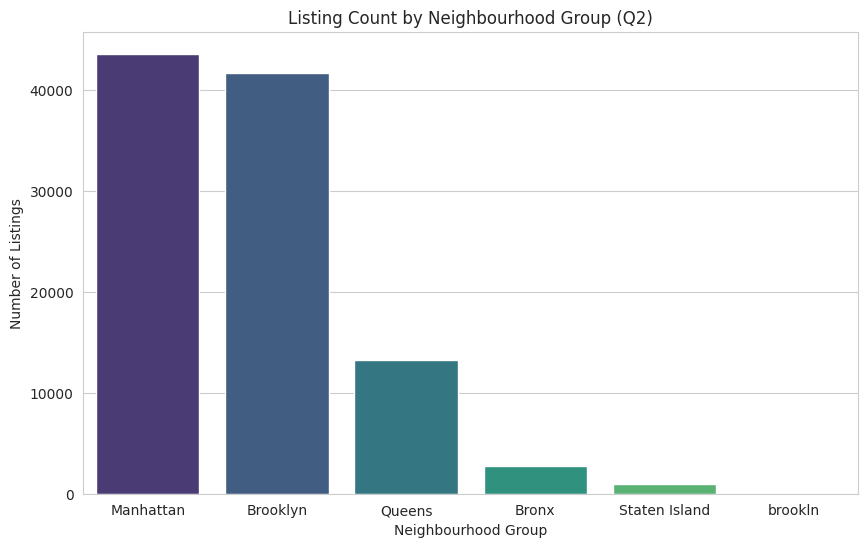

In [7]:
print("\n2. Neighborhood Group with Highest Number of Listings:")
listing_counts = df['neighbourhood_group'].value_counts()
highest_listings_group = listing_counts.idxmax()
print(f"The neighborhood group with the highest number of listings is: {highest_listings_group} ({listing_counts.max()})")

# Visualization for Q2
plt.figure(figsize=(10, 6))
sns.barplot(x=listing_counts.index, y=listing_counts.values, palette="viridis")
plt.title('Listing Count by Neighbourhood Group (Q2)')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Number of Listings')
plt.show()

Q3: Which neighborhood group have the highest average prices for Airbnb listings?


3. Neighborhood Group with Highest Average Price:
The neighborhood group with the highest average price is: Queens ($630.13)


/tmp/ipython-input-2523455232.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_by_group.index, y=avg_price_by_group.values, palette="rocket")


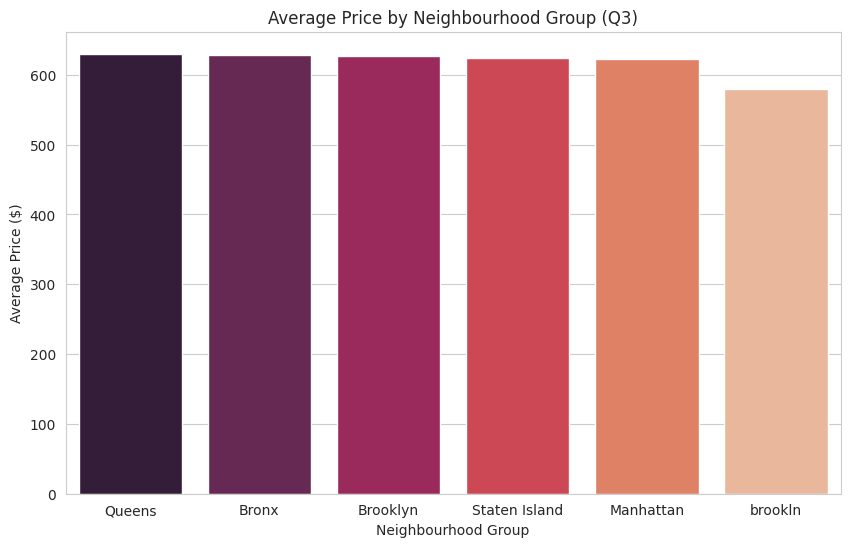

In [8]:
print("\n3. Neighborhood Group with Highest Average Price:")
avg_price_by_group = df.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=False)
highest_price_group = avg_price_by_group.index[0]
print(f"The neighborhood group with the highest average price is: {highest_price_group} (${avg_price_by_group.max():.2f})")

# Visualization for Q3
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_price_by_group.index, y=avg_price_by_group.values, palette="rocket")
plt.title('Average Price by Neighbourhood Group (Q3)')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Price ($)')
plt.show()

Q4: Is there a relationship between the construction year of property and price?

In [9]:
print("\n4. Relationship between Construction Year and Price:")
# Calculate Pearson correlation coefficient
correlation_year_price = df[['construction_year', 'price']].corr().iloc[0, 1]
print(f"The correlation between Construction Year and Price is: {correlation_year_price:.4f}")
if abs(correlation_year_price) < 0.1:
    print("This indicates a very weak to no linear relationship.")
else:
    print("This indicates a notable relationship.")


4. Relationship between Construction Year and Price:
The correlation between Construction Year and Price is: -0.0037
This indicates a very weak to no linear relationship.


Q5: Who are the top 10 hosts by calculated host listing count?

In [10]:
print("\n5. Top 10 Hosts by Listing Count:")
top_10_hosts = df.groupby('host_id')['calculated_host_listings_count'].max().sort_values(ascending=False).head(10)
print(top_10_hosts)


5. Top 10 Hosts by Listing Count:
host_id
80832323346    332.0
90148229302    332.0
90177049292    332.0
83412943157    332.0
6866703084     332.0
18344435096    332.0
1727019127     332.0
52760110374    332.0
94944787862    332.0
26125388039    332.0
Name: calculated_host_listings_count, dtype: float64


Q6: Are hosts with verified identities more likely to receive positive reviews?

In [11]:
print("\n6. Verified Identity and Positive Reviews (Review Rate Number):")
# Assuming 'review_rate_number' is a numerical score where higher is more positive.
avg_review_by_verification = df.groupby('host_identity_verified')['review_rate_number'].mean().sort_values(ascending=False)
print("Average Review Rate Number by Host Verification Status:")
print(avg_review_by_verification)
if avg_review_by_verification.get('verified', 0) > avg_review_by_verification.get('unconfirmed', 0):
    print("\nCONCLUSION: Verified hosts have a higher average review rate number, suggesting they are more likely to receive positive reviews.")
else:
    print("\nCONCLUSION: Verification status does not show a clear advantage in positive reviews based on this metric.")


6. Verified Identity and Positive Reviews (Review Rate Number):
Average Review Rate Number by Host Verification Status:
host_identity_verified
verified       3.278024
unconfirmed    3.259394
Name: review_rate_number, dtype: float64

CONCLUSION: Verified hosts have a higher average review rate number, suggesting they are more likely to receive positive reviews.


Q7: Is there a correlation between the price of a listing and its service fee?

In [12]:
print("\n7. Correlation between Price and Service Fee:")
correlation_price_fee = df[['price', 'service_fee']].corr().iloc[0, 1]
print(f"The correlation between Price and Service Fee is: {correlation_price_fee:.4f}")
if correlation_price_fee > 0.7:
    print("This indicates a strong positive correlation (as price increases, so does the service fee).")
else:
    print("This indicates a moderate or weak correlation.")


7. Correlation between Price and Service Fee:
The correlation between Price and Service Fee is: 1.0000
This indicates a strong positive correlation (as price increases, so does the service fee).


Q8: What is the average review rate number and does it vary based on neighborhood group and room type?

In [13]:
print("\n8. Average Review Rate Number (Overall and by Group/Type):")
overall_avg_review = df['review_rate_number'].mean()
print(f"Overall Average Review Rate Number: {overall_avg_review:.2f}")

# Grouped Analysis
grouped_review = df.groupby(['neighbourhood_group', 'room_type'])['review_rate_number'].mean().unstack()
print("\nAverage Review Rate Number by Neighbourhood Group and Room Type:")
print(grouped_review)


8. Average Review Rate Number (Overall and by Group/Type):
Overall Average Review Rate Number: 3.27

Average Review Rate Number by Neighbourhood Group and Room Type:
room_type            Entire home/apt  Hotel room  Private room  Shared room
neighbourhood_group                                                        
Bronx                       3.329735         NaN      3.301151     3.264957
Brooklyn                    3.240738        3.75      3.255090     3.324786
Manhattan                   3.265336        3.50      3.266609     3.257206
Queens                      3.347520        3.75      3.301466     3.359116
Staten Island               3.307203         NaN      3.460043     3.533333
brookln                          NaN         NaN      4.000000          NaN


 Q9: Are hosts with a higher calculated host listings count more likely to maintain higher availability throughout the year?


9. Listing Count and Availability:
The correlation between Host Listing Count and Availability (365 days) is: 0.1598
This indicates a very weak to no linear relationship.


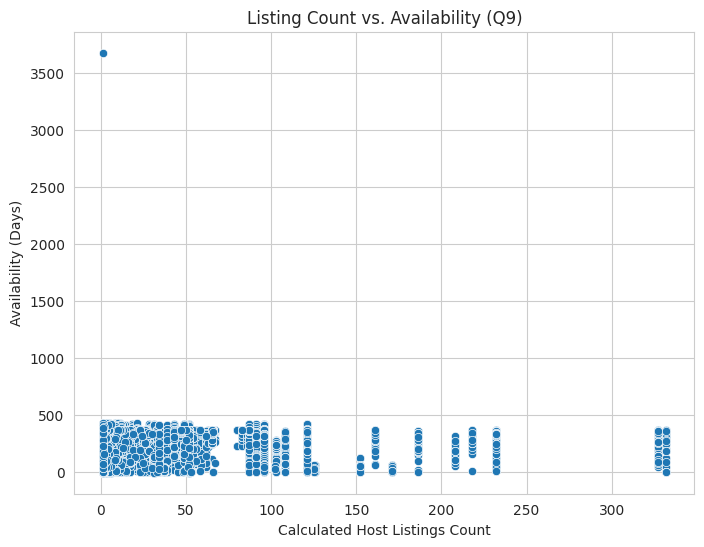

In [14]:
print("\n9. Listing Count and Availability:")

# Calculate correlation between 'calculated_host_listings_count' and 'availability_365'
correlation_count_availability = df[['calculated_host_listings_count', 'availability_365']].corr().iloc[0, 1]
print(f"The correlation between Host Listing Count and Availability (365 days) is: {correlation_count_availability:.4f}")
if correlation_count_availability > 0.2:
    print("This indicates a weak to moderate positive relationship (more listings tends to correlate with slightly higher overall availability).")
elif correlation_count_availability < -0.2:
    print("This indicates a weak to moderate negative relationship.")
else:
    print("This indicates a very weak to no linear relationship.")

#  Visualize the relationship
plt.figure(figsize=(8, 6))
sns.scatterplot(x='calculated_host_listings_count', y='availability_365', data=df)
plt.title('Listing Count vs. Availability (Q9)')
plt.xlabel('Calculated Host Listings Count')
plt.ylabel('Availability (Days)')
plt.show()

# AI based system to recommend or suggests listings based on user preferences

In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import cosine_similarity


# Clean column names (lowercase, replace spaces with _)
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Select useful features
features = ['price','service_fee','minimum_nights','number_of_reviews',
            'availability_365','neighbourhood_group','room_type',
            'cancellation_policy','instant_bookable','host_identity_verified']

data = df[features].copy()

# Handle missing values
for col in ['price','service_fee','minimum_nights','number_of_reviews','availability_365']:
    data[col].fillna(data[col].median(), inplace=True)

for col in ['neighbourhood_group','room_type','cancellation_policy','instant_bookable','host_identity_verified']:
    # Convert to string type before filling NaN to ensure uniform type
    data[col] = data[col].astype(str).fillna("Unknown")


# Define column types
num_cols = ['price','service_fee','minimum_nights','number_of_reviews','availability_365']
cat_cols = ['neighbourhood_group','room_type','cancellation_policy','instant_bookable','host_identity_verified']

# Preprocessor: scale numeric + one-hot encode categoricals
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# Fit-transform dataset
features_transformed = preprocessor.fit_transform(data)


def recommend_from_preferences(budget, nights, reviews, n=5):
    user_pref = pd.DataFrame([{
        'price': budget,
        'service_fee': df['service_fee'].median(),  # default value
        'minimum_nights': nights,
        'number_of_reviews': reviews,
        'availability_365': df['availability_365'].median(),
        'neighbourhood_group': "Manhattan",   # you can change this
        'room_type': "Entire home/apt",       # you can change this
        'cancellation_policy': "flexible",    # you can change this
        'instant_bookable': "t",
        'host_identity_verified': "verified"
    }])

    user_transformed = preprocessor.transform(user_pref)
    scores = cosine_similarity(user_transformed, features_transformed)[0]
    top_indices = scores.argsort()[::-1][0:n]
    return df.iloc[top_indices][['name','neighbourhood_group','room_type',
                                 'price','number_of_reviews','availability_365']]

# Example: user wants budget ~150 USD, 3 nights, 20 reviews
print("\nRecommendations for user preferences:")
print(recommend_from_preferences(150, 3, 20, 5))

/tmp/ipython-input-1337401793.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)



Recommendations for user preferences:
                                                   name neighbourhood_group  \
40523                    Serenity Studio in East Harlem           Manhattan   
41492                          Quiet 1bedroom apartment           Manhattan   
74099                          Quiet 1bedroom apartment           Manhattan   
32371                  Hip All Stone East Village Condo           Manhattan   
29055  Manhattan Club Luxury Condo Central Park - Suite           Manhattan   

             room_type  price  number_of_reviews  availability_365  
40523  Entire home/apt  373.0               20.0              81.0  
41492  Entire home/apt  338.0               23.0             106.0  
74099  Entire home/apt  338.0               23.0             106.0  
32371  Entire home/apt  332.0               11.0              88.0  
29055  Entire home/apt  306.0               13.0              65.0  


# Conclusion

1. Loading dataset
2. Cleaning and Wrangling
3. EDA and data visualization of following questions
4. AI model to predict recomendations for your next hotel booking